In [265]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [266]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [267]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)

<h4>Creating Dictionary Keys</h4>

In [268]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [269]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [270]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [271]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [272]:
# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[old_df[0]]
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[new_df[0]]
latest_sel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1689 non-null   object        
 1   CNTR_ID     1689 non-null   object        
 2   POD_ID      1689 non-null   object        
 3   ETD_POL_D   1689 non-null   object        
 4   PARTY_ID    1689 non-null   object        
 5   PARTY_NAME  1689 non-null   object        
 6   POD         1689 non-null   datetime64[ns]
 7   CNTR_SIZE   1689 non-null   object        
 8   CNTR_TYPE   1689 non-null   object        
 9   RATE        1689 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object

<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [273]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200077,010000419950,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
1,ECS010230200077,010000406570,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
2,ECS010230200078,010000432251,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
20,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
21,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
22,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      23 non-null     object        
 1   CNTR_ID     23 non-null     object        
 2   POD_ID      23 non-null     object        
 3   ETD_POL_D   23 non-null     object        
 4   PARTY_ID    23 non-null     object        
 5   PARTY_NAME  23 non-null     object        
 6   POD         23 non-null     datetime64[ns]
 7   CNTR_SIZE   23 non-null     object        
 8   CNTR_TYPE   23 non-null     object        
 9   RATE        23 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.9+ KB


In [274]:
# Interpolate using spline interpolation

# Remove duplicated dates and cost rows
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Remove features that are not important
sel_feat = ['POD','RATE']
sel_df = sel_df[sel_feat]

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=sel_df['POD'].min(), end=sel_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, sel_df, on='POD', how='left')

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='spline', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(2)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-10-03,390.00
1,2005-10-04,390.07
2,2005-10-05,390.06
3,2005-10-06,390.06
4,2005-10-07,390.00


,POD,RATE
6371,2023-02-24,300.0
6372,2023-02-25,300.0
6373,2023-02-26,300.0
6374,2023-02-27,300.0
6375,2023-02-28,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6376 entries, 0 to 6375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6376 non-null   datetime64[ns]
 1   RATE    6376 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.4 KB


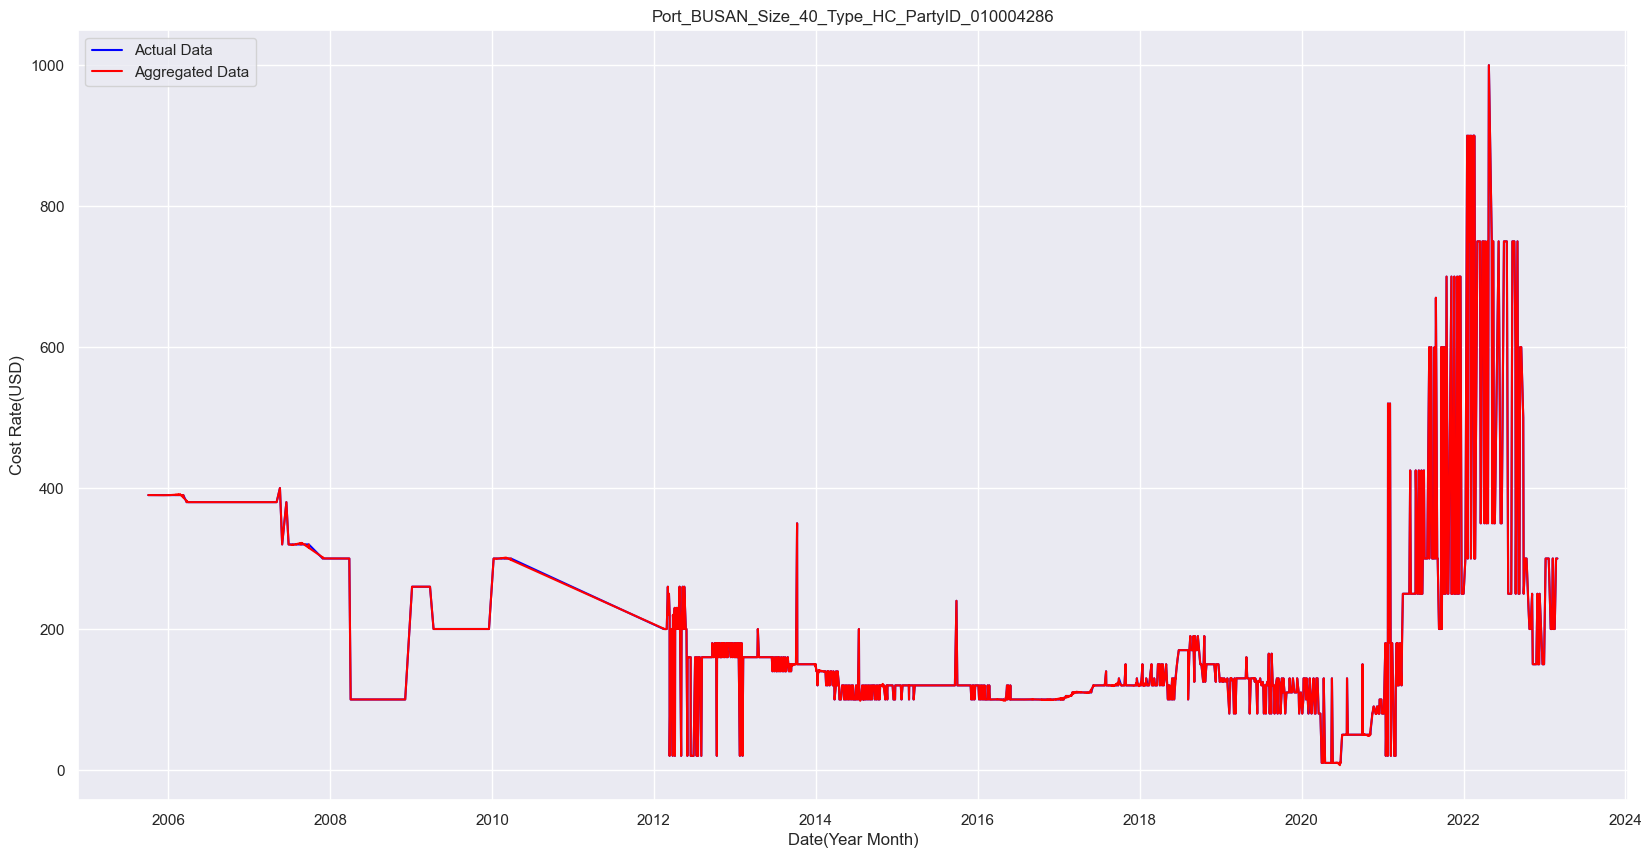

In [275]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='red', label="Aggregated Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

<h4>Mean Square Error Evaluation Function</h4>

In [276]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>LSTM Regression<h4>

In [277]:
def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

<h4>Modeling For ARIMA<h4>

In [278]:
df_arima1 = df_interpolated[['POD','RATE']].copy()
df_arima1.set_index('POD', inplace=True)
df_arima1.head()
df_arima1.info()

,RATE
POD,
2005-10-03,390.00
2005-10-04,390.07
2005-10-05,390.06
2005-10-06,390.06
2005-10-07,390.00


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6376 entries, 2005-10-03 to 2023-02-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RATE    6376 non-null   float64
dtypes: float64(1)
memory usage: 99.6 KB


In [279]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Split the data into training and test data
train_size2 = int(len(df_arima1) * 0.7)
train2, test2 = df_arima1[0:train_size2], df_arima1[train_size2:]

# Fit an auto_arima model
arima_model2 = pm.auto_arima(train2['RATE'], start_p=1, start_q=1, 
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=False, 
                            d=0, D=0, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)  # set to stepwise

# Print the summary of the model
print(arima_model2.summary())

# Forecast
train_forecast2 = arima_model2.predict_in_sample()
test_forecast2 = arima_model2.predict(n_periods=len(test2))

# Calculate the RMSE
RMSE_ARIMA_train2 = np.sqrt(mean_squared_error(train2['RATE'], train_forecast2))
print("Train RMSE: %.3f" % RMSE_ARIMA_train2)
RMSE_ARIMA_test2 = np.sqrt(mean_squared_error(test2['RATE'], test_forecast2))
print("Test RMSE: %.3f" % RMSE_ARIMA_test2)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=33531.535, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61041.360, Time=0.04 sec


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=55195.030, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=33523.371, Time=0.78 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=33525.022, Time=1.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=33524.987, Time=1.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=33527.677, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=33519.956, Time=2.08 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=33300.783, Time=1.31 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=33515.017, Time=1.63 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=33299.197, Time=4.18 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=33318.015, Time=3.68 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=33463.734, Time=4.46 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=33515.780, Time=2.80 sec

Best model: 

c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<h4>Forecast the results</h4>

In [280]:
def forecast_next_days(model, n_steps):
    # Predict the next n_steps values
    prediction = model.predict(n_periods=n_steps, return_conf_int=False)
    
    # Return the prediction
    return prediction


In [281]:
# How many days you want to forecast
days = 240

# Forecast the next 240 days
forecasted_values = forecast_next_days(arima_model2, days)

# Get the last date from 'POD'
last_date = df_interpolated['POD'].iloc[-1]

# Create new dates
new_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=days)

# Create a new DataFrame for the forecasted values
df_forecasted = pd.DataFrame(data={'POD': new_dates, 'RATE': forecasted_values})

# Rounding of the rate nearest 2 decimal point
df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()

c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,POD,RATE
4463,2023-03-01,120.54
4464,2023-03-02,120.68
4465,2023-03-03,120.78
4466,2023-03-04,120.86
4467,2023-03-05,120.93


,POD,RATE
4698,2023-10-22,140.13
4699,2023-10-23,140.20
4700,2023-10-24,140.28
4701,2023-10-25,140.35
4702,2023-10-26,140.43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 4463 to 4702
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     240 non-null    datetime64[ns]
 1   RATE    240 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


<h4>Comparing with actual updated against forecasted</h4>

In [282]:
# Merge the two dataframes on the 'POD' column
comparison_df = pd.merge(df_forecasted, new_dates_df, on='POD', how='inner', suffixes=('_forecasted', '_actual'))

# Calculate the absolute error
comparison_df['error'] = abs(comparison_df['RATE_forecasted'] - comparison_df['RATE_actual'])

# Calculate the error as a proportion of the actual rate
comparison_df['error_proportion'] = comparison_df['error'] / comparison_df['RATE_actual']

# Calculate the accuracy as a percentage
comparison_df['accuracy'] = (1 - comparison_df['error_proportion']) * 100

# Rearranging columns
arrange_col = ['POD','RATE_forecasted','RATE_actual','error','error_proportion','accuracy']

comparison_df_v2 = comparison_df[arrange_col]

# Display the comparison dataframe
comparison_df_v2.head(10)
comparison_df.info()


,POD,RATE_forecasted,RATE_actual,error,error_proportion,accuracy
0,2023-03-08,121.16,260.0,138.84,0.534000,46.600000
1,2023-03-08,121.16,260.0,138.84,0.534000,46.600000
2,2023-03-15,121.81,260.0,138.19,0.531500,46.850000
3,2023-03-15,121.81,260.0,138.19,0.531500,46.850000
4,2023-03-19,122.17,300.0,177.83,0.592767,40.723333
5,2023-03-26,122.81,260.0,137.19,0.527654,47.234615
6,2023-04-01,123.36,260.0,136.64,0.525538,47.446154
7,2023-04-01,123.36,260.0,136.64,0.525538,47.446154
8,2023-04-08,123.99,260.0,136.01,0.523115,47.688462
9,2023-04-08,123.99,260.0,136.01,0.523115,47.688462


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 22
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   POD               23 non-null     datetime64[ns]
 1   RATE_forecasted   23 non-null     float64       
 2   CSL_ID            23 non-null     object        
 3   CNTR_ID           23 non-null     object        
 4   POD_ID            23 non-null     object        
 5   ETD_POL_D         23 non-null     object        
 6   PARTY_ID          23 non-null     object        
 7   PARTY_NAME        23 non-null     object        
 8   CNTR_SIZE         23 non-null     object        
 9   CNTR_TYPE         23 non-null     object        
 10  RATE_actual       23 non-null     float64       
 11  error             23 non-null     float64       
 12  error_proportion  23 non-null     float64       
 13  accuracy          23 non-null     float64       
dtypes: datetime64[ns](1), float6

<h4>Visualise all, Conclusion</h4>

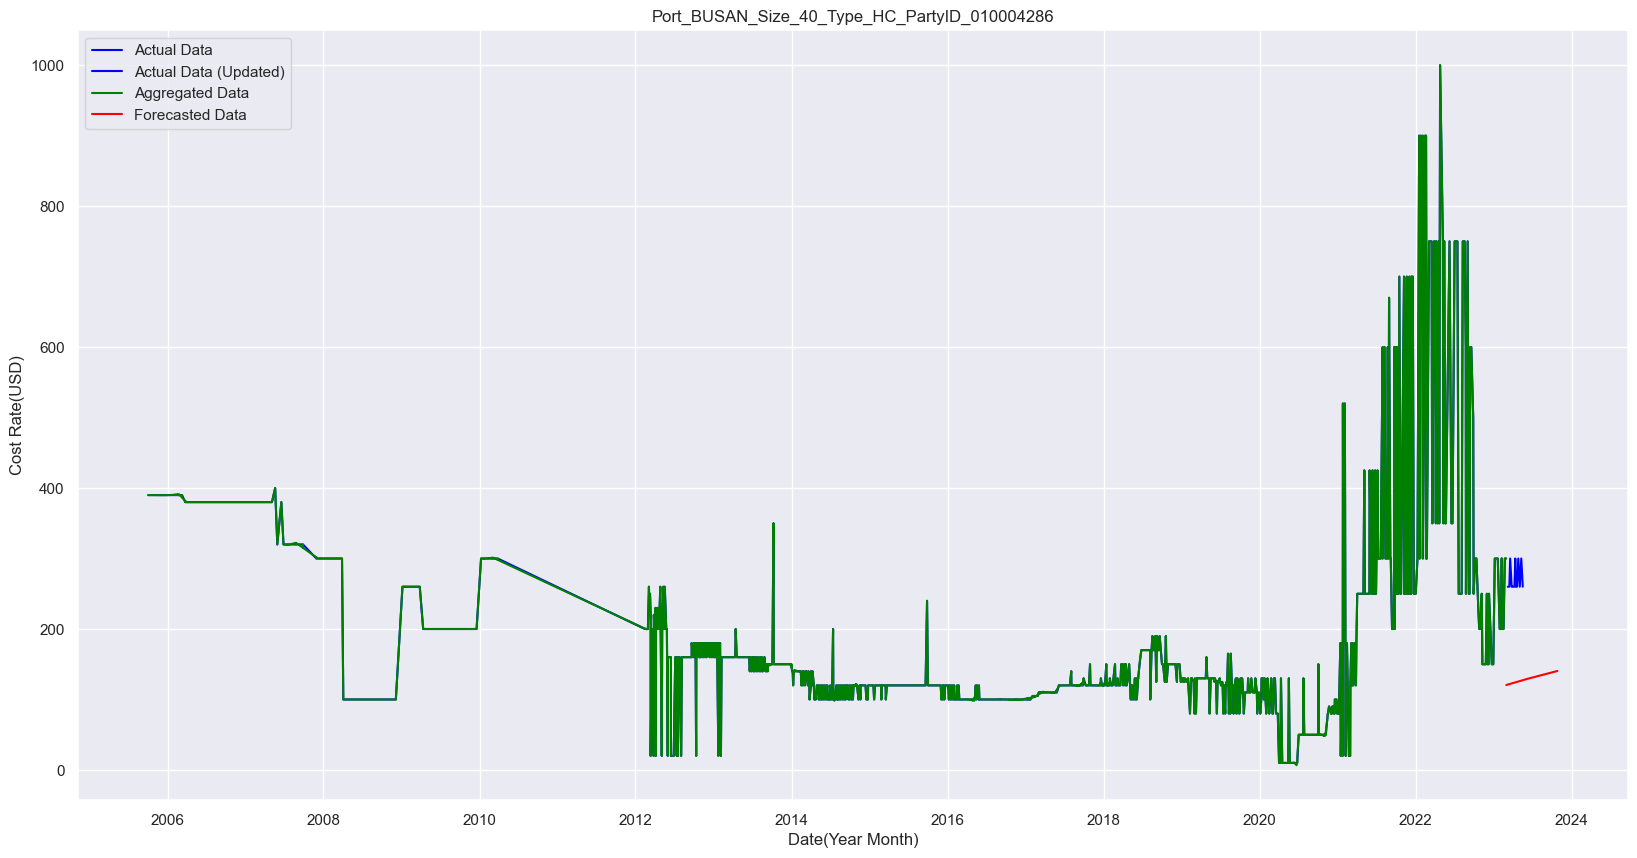

In [283]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

In [284]:
total_mean_accuracy = comparison_df['accuracy'].mean()
print(f'The mean accuracy is {total_mean_accuracy:.2f}%')

The mean accuracy is 46.41%
